In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
import warnings

warnings.filterwarnings('ignore')

PG_HOST='localhost'
PG_DATABASE='grupo_s'
PG_USER='postgres'
PG_PASSWORD='123'

LOCAL_DADOS = 'dados/'
DADOS_COVID = LOCAL_DADOS + 'Bing-COVID19-Data.csv'
DADOS_INDICADORES = LOCAL_DADOS + 'WDIData.csv'
DADOS_CATEGORIAS = LOCAL_DADOS + 'WDISeries.csv'
DADOS_PAISES = LOCAL_DADOS + 'WDICountry.csv'

STRING_CONEXAO = "host="+ PG_HOST +" port="+ "5432" +" dbname=" + \
              PG_DATABASE +" user=" + PG_USER +" password="+ PG_PASSWORD

In [2]:
# Seção de funções auxiliares

def cria_objetos_banco(sql_tuplas):

    cursor = None
    conexao = None

    try:
        conexao = psycopg2.connect(STRING_CONEXAO)
        cursor = conexao.cursor()

        for sql in sql_tuplas:
            cursor.execute(sql)

        cursor.close()
        conexao.commit()

        print('OBJETOS CRIADOS COM SUCESSO.')

    except (Exception, psycopg2.DatabaseError) as error:
        conexao.rollback()
        print(error)
    finally:
        if conexao is not None:
            conexao.close()

#--------------------------------------------------
            
def obter_dataframe(sql, colunas):
    try:
        conexao = psycopg2.connect(STRING_CONEXAO)
        cursor = conexao.cursor()
        cursor.execute(sql)

        resultado = cursor.fetchall()

        cursor.close()

        resultado = pd.DataFrame(resultado, columns=colunas)        

        return resultado
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conexao is not None:
            conexao.close()    

#--------------------------------------------------
            
def obter_sql(pais):
    sql = 'SELECT ac.data_afericao, ac.casos_novos, ' \
        'ac.recuperados_acumulados, ac.mortes_acumuladas ' \
        'FROM afericao_covid ac ' \
        'WHERE 1=1 ' \
        'AND ac.codigo_pais = \'%s\' ' \
        'AND ac.data_afericao BETWEEN \'2020-09-01\' AND \'2021-03-01\'' \
        'ORDER BY ac.data_afericao' % pais
    return sql

In [3]:
#Queries para a criação de objetos de banco

DDL_COVID = (    
    'DROP TABLE IF EXISTS afericao_covid',

    'CREATE TABLE IF NOT EXISTS afericao_covid (' + \
    '	id_afericao serial, ' + \
    '	data_afericao date NOT NULL, ' + \
    '	casos_novos integer, ' + \
    '	casos_acumulados integer, ' + \
    '	recuperados_novos integer, ' + \
    '	recuperados_acumulados integer, ' + \
    '	mortes_novas double precision, ' + \
    '	mortes_acumuladas double precision, ' + \
    '	latitude double precision, ' + \
    '	longitude double precision, ' + \
    '	codigo_pais char(3) ' + \
    ')',
    
    'CREATE INDEX idx_covid_casos_novos ON afericao_covid(casos_novos)',
    'CREATE INDEX idx_covid_casos_acumulados ON afericao_covid(casos_acumulados)',
    'CREATE INDEX idx_covid_mortes_novas ON afericao_covid(mortes_novas)',
    'CREATE INDEX idx_covid_mortes_acumuladas ON afericao_covid(mortes_acumuladas)',
    'CREATE INDEX idx_covid_pais ON afericao_covid(codigo_pais)'
)

DDL_BANCO_MUNDIAL = (
    'DROP TABLE IF EXISTS afericao',
    'DROP TABLE IF EXISTS pais',
    'DROP TABLE IF EXISTS indicador',
    'DROP TABLE IF EXISTS regiao',
    'DROP TABLE IF EXISTS categoria',
    
    'CREATE TABLE IF NOT EXISTS regiao (' + \
    '	codigo_regiao INT,' + \
    '	nome_regiao varchar NOT NULL,' + \
    '	CONSTRAINT PK_codigo_regiao PRIMARY KEY(codigo_regiao) ' + \
    ')',

    'CREATE TABLE IF NOT EXISTS pais ( ' + \
    '	codigo_pais char(3) NOT NULL, ' + \
    '	nome_pais varchar NOT NULL, ' + \
    '	nome_completo varchar NOT NULL, ' + \
    '	unidade_monetaria varchar, ' + \
    '	codigo_regiao INT, ' + \
    '	CONSTRAINT PK_codigo_pais PRIMARY KEY(codigo_pais), ' + \
    '	CONSTRAINT FK_codigo_regiao FOREIGN KEY (codigo_regiao) REFERENCES regiao (codigo_regiao) ' + \
    ')',

    'CREATE TABLE IF NOT EXISTS categoria ( ' + \
    '	codigo_categoria INT, ' + \
    '	descricao_categoria varchar NOT NULL, ' + \
    '	CONSTRAINT PK_codigo_categoria PRIMARY KEY(codigo_categoria) ' + \
    ')',

    'CREATE TABLE IF NOT EXISTS indicador ( ' + \
    '	codigo_indicador varchar NOT NULL, ' + \
    '	nome_indicador varchar NOT NULL, ' + \
    '	codigo_categoria INT NOT NULL, ' + \
    '	CONSTRAINT PK_codigo_indicador PRIMARY KEY(codigo_indicador), ' + \
    '	CONSTRAINT FK_codigo_categoria FOREIGN KEY (codigo_categoria) REFERENCES categoria (codigo_categoria) ' + \
    ')',

    'CREATE TABLE IF NOT EXISTS afericao ( ' + \
    '	codigo_indicador varchar NOT NULL, ' + \
    '	codigo_pais char(3), ' + \
    '	ano_afericao SMALLINT, ' + \
    '	valor_afericao DOUBLE PRECISION, ' + \
    '	CONSTRAINT PK_codigos_indicador_pais_ano PRIMARY KEY(codigo_indicador, codigo_pais, ano_afericao), ' + \
    '	CONSTRAINT FK_codigo_indicador FOREIGN KEY (codigo_indicador) REFERENCES indicador (codigo_indicador) ' + \
    ')',
    
    'CREATE INDEX idx_pais_bra ON afericao(codigo_pais) ' + \
    '	WHERE (codigo_pais = \'BRA\')',
    
    'CREATE EXTENSION IF NOT EXISTS pg_trgm',
    
    'CREATE INDEX idx_parte_cod_indicador ' + \
    '	ON afericao USING GIN(codigo_indicador gin_trgm_ops)',
    
    'CREATE INDEX idx_cod_pais_geral ON afericao(codigo_pais)'
)

DDL_USUARIOS = (
    'DROP ROLE IF EXISTS geral',
    'DROP ROLE IF EXISTS gestores',
    'DROP USER IF EXISTS usuario1',
    'DROP USER IF EXISTS gestor1',
    'DROP USER IF EXISTS gestor2',
    
    'CREATE ROLE geral',
    'GRANT SELECT ON afericao TO geral',
    'GRANT SELECT ON indicador TO geral',
    'GRANT SELECT ON categoria TO geral',
    'GRANT SELECT ON regiao TO geral',
    'GRANT SELECT ON pais TO geral',
    'GRANT SELECT ON afericao_covid TO geral',

    'CREATE USER usuario1 WITH PASSWORD \'12354\'',
    'GRANT geral TO usuario1',

    'CREATE ROLE gestores',
    'GRANT SELECT, UPDATE, DELETE ON pais TO gestores',
    'GRANT SELECT, UPDATE, DELETE ON afericao TO gestores',
    'GRANT SELECT, UPDATE, DELETE ON indicador TO gestores',
    'GRANT SELECT, UPDATE, DELETE ON categoria TO gestores',
    'GRANT SELECT, UPDATE, DELETE ON regiao TO gestores',
    'GRANT SELECT, UPDATE, DELETE ON afericao_covid TO gestores',

    'CREATE USER gestor1 WITH PASSWORD \'12354\'',
    'CREATE USER gestor2 WITH PASSWORD \'12354\'',

    'GRANT gestores TO gestor1',
    'GRANT gestores TO gestor2'
)

DDL_TRIGGERS = (
    'CREATE OR REPLACE FUNCTION bloquear_operacao_geral() ' + \
    '    RETURNS TRIGGER LANGUAGE plpgsql AS $$ ' + \
    'BEGIN ' + \
    '  RETURN null; ' + \
    'END $$;',

    'CREATE TRIGGER tg_evitar_delete BEFORE DELETE ' + \
    '    ON afericao_covid FOR EACH ROW EXECUTE PROCEDURE bloquear_operacao_geral()',

    'CREATE TRIGGER tg_evitar_delete BEFORE DELETE ' + \
    '    ON afericao FOR EACH ROW EXECUTE PROCEDURE bloquear_operacao_geral()'
)


In [4]:
#Bloco para criação dos objetos de banco da COVID-19
cria_objetos_banco(DDL_COVID)

OBJETOS CRIADOS COM SUCESSO.


In [5]:
#Bloco para a carga de dados da COVID-19

df_covid = pd.read_csv(DADOS_COVID)[['Updated','ConfirmedChange','Confirmed','RecoveredChange',
                                     'Recovered','DeathsChange','Deaths','Latitude','Longitude','ISO3']]
df_covid['Updated'] = list(map(lambda x : x[6:10] + '-' + x[0:2] + '-' + x[3:5], df_covid['Updated']))
df_covid = df_covid.where(pd.notnull(df_covid), None) #substitui os valores NaN por NULL

conexao = None

try:

    conexao = psycopg2.connect(STRING_CONEXAO)
    cursor = conexao.cursor()   
    
    print('INSERINDO AFERIÇÕES COVID...')
    
    #Povoa a tabela de aferições
    for i, linha in df_covid.iterrows():
        sql = 'INSERT INTO afericao_covid(data_afericao, casos_novos, casos_acumulados, ' \
            'recuperados_novos, recuperados_acumulados, mortes_novas, mortes_acumuladas,' \
            'latitude, longitude, codigo_pais) ' \
            'VALUES (' + '%s,' *(len(linha)-1) + '%s)'

        cursor.execute(sql, tuple(linha))

    conexao.commit()

    print('AFERIÇÕES COVID INSERIDAS COM SUCESSO.')

except (Exception, psycopg2.DatabaseError) as error:
    conexao.rollback()
    print(error)
finally:
    if conexao is not None:
        conexao.close()

INSERINDO AFERIÇÕES COVID...
AFERIÇÕES COVID INSERIDAS COM SUCESSO.


In [6]:
#Bloco para criação dos objetos de banco de dados do Banco Mundial
cria_objetos_banco(DDL_BANCO_MUNDIAL)

OBJETOS CRIADOS COM SUCESSO.


In [7]:
#Bloco para a carga de dados do Banco Mundial

conexao = None

try:
    
    conexao = psycopg2.connect(STRING_CONEXAO)
    cursor = conexao.cursor()

    df_paises = pd.read_csv(DADOS_PAISES)[['Country Code','Short Name','Long Name','Currency Unit','Region']]
    df_paises = df_paises.where(pd.notnull(df_paises), None)
    df_regioes = df_paises[['Region']].drop_duplicates().sort_values('Region').dropna()
    df_regioes['IdRegion'] = list(range(1,len(df_regioes) + 1))
    
    #-------------------------------------------------
    # Povoa a tabela de REGIÕES    
    print('INSERINDO REGIÕES...')
    for i, linha in df_regioes.iterrows():
        sql = "INSERT INTO regiao(nome_regiao, codigo_regiao) " \
            "VALUES (" + "%s," *(len(linha)-1) + "%s)"

        cursor.execute(sql, tuple(linha))  

    print('REGIÕES INSERIDAS COM SUCESSO.')
    print('-')

    # Join entre os datasets de PAÍSES e REGIÕES
    df_paises_regioes = pd.merge(df_paises, df_regioes, on=['Region'])[['Country Code','Short Name','Long Name','Currency Unit','IdRegion']]
    
    #-------------------------------------------------
    # Povoa a tabela de PAÍSES
    print('INSERINDO PAÍSES...')
    for i, linha in df_paises_regioes.iterrows():
        sql = "INSERT INTO pais(codigo_pais, nome_pais, nome_completo, unidade_monetaria, codigo_regiao) " \
            "VALUES (" + "%s," *(len(linha)-1) + "%s)"

        cursor.execute(sql, tuple(linha))

    print('PAISES INSERIDOS COM SUCESSO.')
    print('-')
    
    #-------------------------------------------------
    #Trabalho para a tabela de CATEGORIAS
    df_categorias = pd.read_csv(DADOS_CATEGORIAS)[['Topic']].drop_duplicates().sort_values('Topic').dropna()
    df_categorias['IdTopic'] = list(range(1,len(df_categorias) + 1))
    
    # Povoa a tabela de CATEGORIAS
    print('INSERINDO CATEGORIAS...')    
    for i, linha in df_categorias.iterrows():
        sql = "INSERT INTO categoria(descricao_categoria, codigo_categoria) " \
            "VALUES (" + "%s," *(len(linha)-1) + "%s)"

        cursor.execute(sql, tuple(linha))

    print('CATEGORIAS INSERIDAS COM SUCESSO.')
    print('-')
    
    #-------------------------------------------------
    # Trabalho para a tabela de INDICADORES
    df_indicadores = pd.read_csv(DADOS_CATEGORIAS)[['Series Code','Indicator Name','Topic']]

    # Join entre os datasets de categorias e indicadores
    df_indicadores_final = pd.merge(df_categorias, df_indicadores, on=['Topic'])[['Series Code','Indicator Name','IdTopic']]

    # Povoa a tabela de INDICADORES    
    print('INSERINDO INDICADORES...')    
    for i, linha in df_indicadores_final.iterrows():
        sql = "INSERT INTO indicador(codigo_indicador, nome_indicador, codigo_categoria) " \
            "VALUES (" + "%s," *(len(linha)-1) + "%s)"

        cursor.execute(sql, tuple(linha))

    print('INDICADORES INSERIDOS COM SUCESSO.')
    print('-')
    
    #-------------------------------------------------
    # Trabalho para a tabela de AFERIÇÕES   
    
    #Region entra aqui apenas para filtrar o Dataset
    df_paises_compacto = df_paises[['Country Code','Region']]
    df_indicadores = pd.read_csv(DADOS_INDICADORES)
    df_indicadores = df_indicadores.where(pd.notnull(df_indicadores), None) #substitui os valores NaN por NULL
    df_afericoes = pd.merge(df_paises_compacto, df_indicadores, on=['Country Code'])
#    df_afericoes = df_afericoes[df_afericoes.Region == 'Latin America & Caribbean']
#     df_afericoes = df_afericoes[df_afericoes['Country Code'] == 'BRA']
    
    # Etapa para converter as colunas de anos em registros na tabela
    # O dataset é quebrado em duas partes: uma com os dados já normais e 
    # outra (a dos anos) com os dados a normalizar.
    # Os anos de 1960 a 2018 estão em colunas e em cada uma dela há o valor da aferição.
    # A ideia é transformar os anos e valores em respectivos registros dos indicadores.
    df_parte1 = df_afericoes[['Indicator Code','Country Code']]
    df_parte1['Year'] = 0
    df_parte1['Values'] = 0.0
    
    #Aqui o slice vai cercar o ano de 2018
    df_parte2 = df_afericoes[df_afericoes.columns[-2:-1]] 
    
    sql = "INSERT INTO afericao(codigo_indicador, codigo_pais, ano_afericao, valor_afericao) " \
            "VALUES (%s, %s, %s, %s)"
        
    # Povoa a tabela de AFERIÇÕES    
    print('INSERINDO AFERIÇÕES BANCO MUNDIAL...')
    
    parametros = []
    
    for i,linha1 in df_parte1.iterrows():        
        linha2 = df_parte2.loc[i,:]
        for coluna in df_parte2.columns:
            parametros.append(linha1['Indicator Code'])
            parametros.append(linha1['Country Code'])
            parametros.append(coluna)
            parametros.append(linha2[coluna])
            
            cursor.execute(sql, tuple(parametros))                
            
            parametros = []   

    print('AFERIÇÕES INSERIDAS COM SUCESSO.')
    print('********************************')
    print('BASE CRIADA COM SUCESSO.')

    conexao.commit()

except (Exception, psycopg2.DatabaseError) as error:
    conexao.rollback()
    print(error)
finally:
    if conexao is not None:
        conexao.close()

INSERINDO REGIÕES...
REGIÕES INSERIDAS COM SUCESSO.
-
INSERINDO PAÍSES...
PAISES INSERIDOS COM SUCESSO.
-
INSERINDO CATEGORIAS...
CATEGORIAS INSERIDAS COM SUCESSO.
-
INSERINDO INDICADORES...
INDICADORES INSERIDOS COM SUCESSO.
-
INSERINDO AFERIÇÕES BANCO MUNDIAL...
AFERIÇÕES INSERIDAS COM SUCESSO.
********************************
BASE CRIADA COM SUCESSO.


In [8]:
cria_objetos_banco(DDL_TRIGGERS)

OBJETOS CRIADOS COM SUCESSO.


In [9]:
cria_objetos_banco(DDL_USUARIOS)

OBJETOS CRIADOS COM SUCESSO.


**ANÁLISE COM OS GRÁFICOS

In [10]:
# importação das libs gráficas
import matplotlib
import matplotlib.pyplot as plt

In [11]:
# definição dos data frames

COLUNAS = ['data_afericao','casos_novos','recuperados_acumulados','mortes_acumuladas']

# Dataframe para Alemanha
sql_alemanha = obter_sql('DEU')
df_alemanha = obter_dataframe(sql_alemanha, COLUNAS)
# Dataframe para Itália
sql_italia = obter_sql('ITA')
df_italia = obter_dataframe(sql_italia, COLUNAS)
# Dataframe para Rússia
sql_russia = obter_sql('RUS')
df_russia = obter_dataframe(sql_russia, COLUNAS)
# Dataframe para Espanha
sql_espanha = obter_sql('ESP')
df_espanha = obter_dataframe(sql_espanha, COLUNAS)
# Dataframe para Ucrânia
sql_ucrania = obter_sql('UKR')
df_ucrania = obter_dataframe(sql_ucrania, COLUNAS)

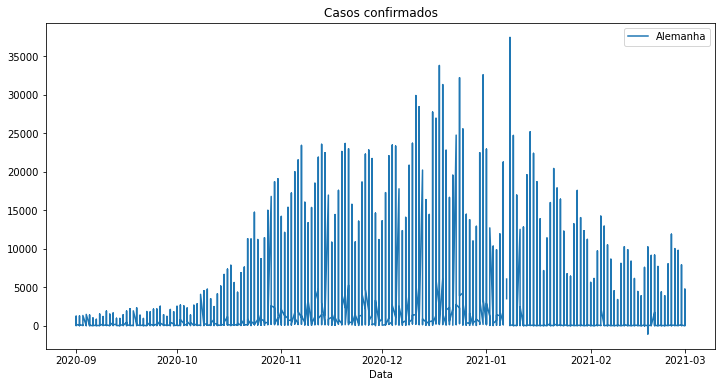

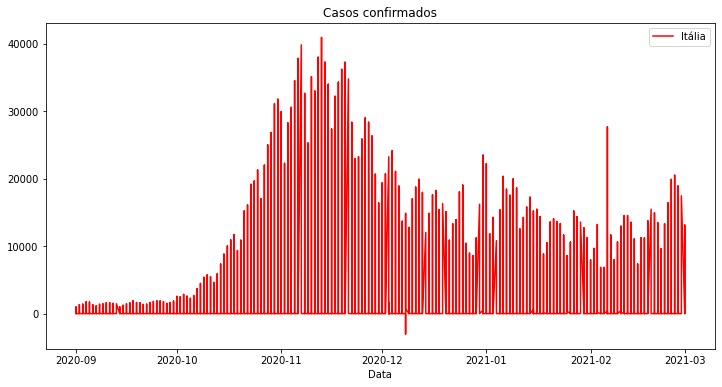

In [12]:
# gráfico 1: (linhas)

# plot da Alemanha
fig= plt.figure(figsize=(12,6))
ax = plt.gca()
    
df_alemanha.plot(title='Casos confirmados',label='Alemanha',kind='line',x='data_afericao',y='casos_novos',ax=ax)
    
plt.xlabel("Data")
plt.show()

#--------------------------------------------
# plot da Itália

fig= plt.figure(figsize=(12,6))
ax = plt.gca()
    
df_italia.plot(title='Casos confirmados',label='Itália',kind='line',x='data_afericao',y='casos_novos', color='red', ax=ax)
    
plt.xlabel("Data")

plt.show()

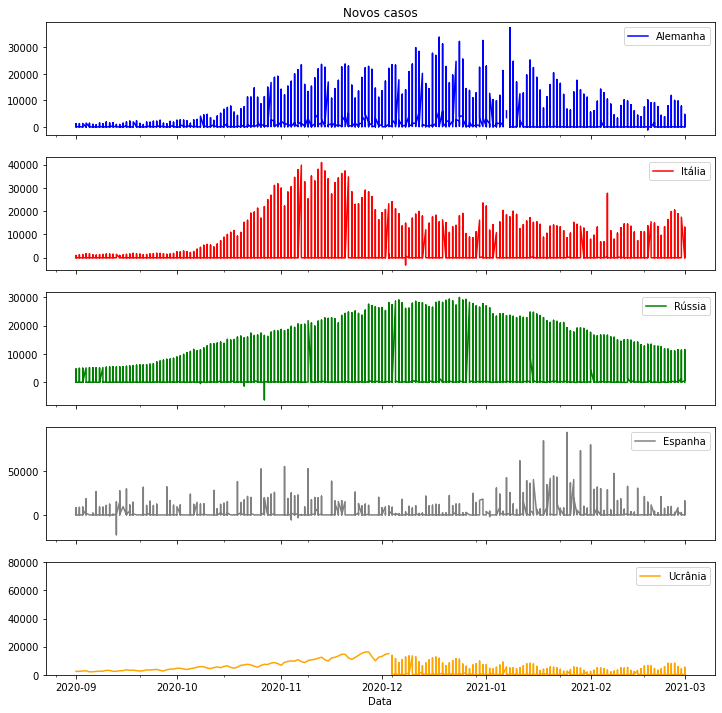

In [13]:
# gráfico 2 (linhas)

figure, axes = plt.subplots(5, 1, True,figsize=(12,12))

plt.ylim([0, 80000])

ax1 = df_alemanha.plot(x='data_afericao',y='casos_novos',color='blue',ax=axes[0],label='Alemanha')
ax2 = df_italia.plot(x='data_afericao',y='casos_novos',color='red',ax=axes[1],label='Itália')
ax3 = df_russia.plot(x='data_afericao',y='casos_novos',color='green',ax=axes[2],label='Rússia')
ax4 = df_espanha.plot(x='data_afericao',y='casos_novos',color='grey',ax=axes[3],label='Espanha')
ax5 = df_ucrania.plot(x='data_afericao',y='casos_novos',color='orange',ax=axes[4],label='Ucrânia')

plt.xlabel('Data')
ax1.set_title('Novos casos')

plt.show()

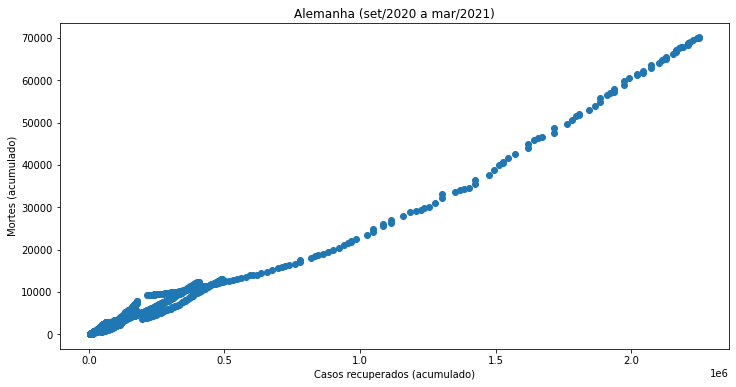

In [14]:
#gráfico 3 (scatter)

figure, axes = plt.subplots(1, 1, True,figsize=(12,6))

plt.scatter(df_alemanha['recuperados_acumulados'],df_alemanha['mortes_acumuladas'])
plt.title('Alemanha (set/2020 a mar/2021)')
plt.ylabel('Mortes (acumulado)')
plt.xlabel('Casos recuperados (acumulado)')
plt.show()

<AxesSubplot:title={'center':'Histograma de densidade de médicos (ano de 2015)'}, xlabel='Médicos por 1000 habitantes', ylabel='Frequência'>

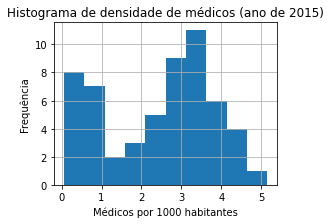

In [15]:
#gráfico 4: barras (histograma)

#df_indicadores = pd.read_csv(DADOS_INDICADORES)
df_doctor_1000 = df_indicadores[(df_indicadores['Indicator Code']=='SH.MED.PHYS.ZS')]

fig= plt.figure(figsize=(4,3))
hist = df_doctor_1000['2015'].hist(bins=10)
plt.title('Histograma de densidade de médicos (ano de 2015)')
plt.xlabel('Médicos por 1000 habitantes')
plt.ylabel('Frequência')
hist